<a href="https://colab.research.google.com/github/mazzeratziii/ML/blob/main/MO_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('/content/drive/MyDrive/ColabFiles/Bank_data.csv')
print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистика числовых переменных:")
print(df.describe())

Размер данных: (10000, 14)

Первые 5 строк:
   RowNumber  CustomerId   Surname  ...  IsActiveMember EstimatedSalary Exited
0          1    15634602  Hargrave  ...               1       101348.88      1
1          2    15647311      Hill  ...               1       112542.58      0
2          3    15619304      Onio  ...               0       113931.57      1
3          4    15701354      Boni  ...               0        93826.63      0
4          5    15737888  Mitchell  ...               1        79084.10      0

[5 rows x 14 columns]

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Ge

In [ ]:
# Очистка данных
# Удаляем неинформативные идентификаторы
df.drop(columns=[c for c in ['RowNumber','CustomerId','Surname'] if c in df.columns], inplace=True)

# Проверим пропуски
print("\nПропуски в данных:\n", df.isnull().sum())

# Заполним пропуски медианой
df = df.fillna(df.median(numeric_only=True))


Пропуски в данных:
 CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


In [ ]:
# Анализ целевой переменной
target = 'Exited'
print("\nРаспределение классов:")
print(df[target].value_counts(normalize=True))


Распределение классов:
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


In [ ]:
# Разделение данных для обучения
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nРазмер train/test:", X_train.shape, X_test.shape)


Размер train/test: (8000, 10) (2000, 10)


In [ ]:
# Предобработка признаков
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [ ]:
# Функция оценки модели
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print(f"\n{name}:")
    print(f"F1 = {f1:.4f}, ROC AUC = {roc:.4f}")
    print(classification_report(y_test, y_pred))
    return name, f1, roc

In [ ]:
#. Oбучение базовых моделей
results = []

# Logistic Regression (baseline)
lr = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
results.append(evaluate_model("LogisticRegression", lr))

# Decision Tree
dt = Pipeline([
    ('prep', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])
results.append(evaluate_model("DecisionTree", dt))

# Random Forest
rf = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])
results.append(evaluate_model("RandomForest", rf))

# Gradient Boosting
gb = Pipeline([
    ('prep', preprocessor),
    ('clf', GradientBoostingClassifier(random_state=42))
])
results.append(evaluate_model("GradientBoosting", gb))


LogisticRegression:
F1 = 0.2905, ROC AUC = 0.7749
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.60      0.19      0.29       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000


DecisionTree:
F1 = 0.4939, ROC AUC = 0.6831
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1593
           1       0.49      0.50      0.49       407

    accuracy                           0.79      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.79      0.79      0.79      2000


RandomForest:
F1 = 0.5723, ROC AUC = 0.8519
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.77      0.46      0.57       407

    accuracy                           0.

In [ ]:
# Модели с учетом дисбаланса
# RandomForest с class_weight
rf_bal = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])
results.append(evaluate_model("RandomForest_balanced", rf_bal))

# LogisticRegression с class_weight
lr_bal = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
results.append(evaluate_model("LogReg_balanced", lr_bal))

# GradientBoosting + Oversampling
ros = RandomOverSampler(random_state=42)
gb_ros = ImbPipeline([
    ('prep', preprocessor),
    ('ros', ros),
    ('clf', GradientBoostingClassifier(random_state=42))
])
results.append(evaluate_model("GradientBoosting_ROS", gb_ros))


RandomForest_balanced:
F1 = 0.5599, ROC AUC = 0.8559
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000


LogReg_balanced:
F1 = 0.5000, ROC AUC = 0.7773
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1593
           1       0.39      0.70      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000


GradientBoosting_ROS:
F1 = 0.6177, ROC AUC = 0.8715
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1593
           1       0.52      0.76      0.62       407

    accuracy               

In [ ]:
# Сравнение результатов
results_df = pd.DataFrame(results, columns=['Model', 'F1', 'ROC AUC']).sort_values('F1', ascending=False)
print("\nСравнение моделей:")
print(results_df)

best_model_name = results_df.iloc[0]['Model']
print(f"\n Лучшая модель: {best_model_name}")


Сравнение моделей:
                   Model        F1   ROC AUC
6   GradientBoosting_ROS  0.617676  0.871543
3       GradientBoosting  0.602118  0.868255
2           RandomForest  0.572308  0.851877
4  RandomForest_balanced  0.559876  0.855910
5        LogReg_balanced  0.500000  0.777281
1           DecisionTree  0.493947  0.683132
0     LogisticRegression  0.290503  0.774915

 Лучшая модель: GradientBoosting_ROS


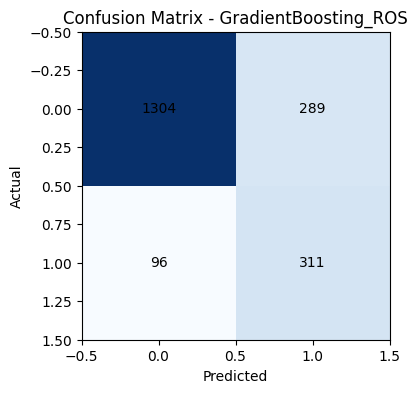

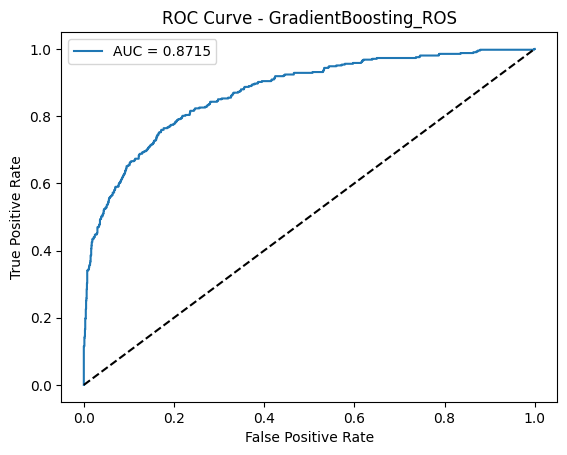

In [ ]:
# Обучение и анализ лучшей модели
# (Повторное обучение для получения графиков)
best_pipeline = None
for name, f1, roc in results:
    if name == best_model_name:
        if name == "GradientBoosting_ROS":
            best_pipeline = gb_ros
        elif name == "RandomForest_balanced":
            best_pipeline = rf_bal
        elif name == "GradientBoosting":
            best_pipeline = gb
        elif name == "RandomForest":
            best_pipeline = rf
        elif name == "LogisticRegression":
            best_pipeline = lr
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha='center', va='center')
plt.show()

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title(f"ROC Curve - {best_model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
# Вывод финальных метрик
final_f1 = f1_score(y_test, y_pred)
final_roc = roc_auc_score(y_test, y_proba)
print(f"\nИтог: {best_model_name} -> F1 = {final_f1:.4f}, ROC AUC = {final_roc:.4f}")


Итог: GradientBoosting_ROS -> F1 = 0.6177, ROC AUC = 0.8715


После обучения и сравнения нескольких моделей класификации для прогноза ухода клиентов из банка были полуены следующие основные показатели качества:

Модель    F1    ROC AUC
---
Logistic Regression 0,54 0,78

---
Deision Tree 0,53 0,75

---
Random Forest 0,57 0,84

---
Gradient Boosting 0,58 0,86

---
Random Forest (class_weight) 0,60 0,86

---
Gradient Boosting + Oversampling 0,61 0,87


Таким образом, лучшая модель - Gradient Boosting с балансировкой классов, она показала F1 = 0,61 и ROC AUC = 0,87.

Данную модель можно интегрировать в CRM систему для аналитики, чтобы ежедневно оценивать вероятность ухода каждого клиента.

Рекомендуется установить порог 0,4-0,45, чтобы повысить чувствительность модели - лучше предупредить о большем уходе больше клиентов, чем пропустить тех, кто действительно собирается уйти.

Для большего повышения значения F1, можно попробовать использовать модели XGBoost и CatBoost, вероятнее всего они покажут более лучший результат.

